### SVM Classsifier

In [1]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy
import seaborn as sns
import sys
import warnings

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from scipy import stats

#### Load Data

In [2]:
data = pd.read_csv('processed_data/combined.csv')
data.head()

,subject_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary
0,sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,...,11197.0,1626.0,2100.0,875.0,5565.0,992979.0,1.0,9.16,ADHD,NaN
1,sub-6568351,5304.9,418.0,12851.3,60354.1,6557.8,3832.1,5498.3,1498.4,763.9,...,11809.0,2032.0,1890.0,1030.0,5512.0,1062350.0,1.0,8.10,Control,NaN
2,sub-0010029,9169.5,632.3,13238.4,55460.8,6471.6,4523.3,6335.9,1977.4,1161.6,...,11704.0,1919.0,1871.0,1277.0,5830.0,1126028.0,1.0,13.09,ADHD,NaN
3,sub-0010027,5143.7,632.3,11137.3,47115.4,6769.7,4062.3,5733.6,1574.8,524.0,...,12703.0,1407.0,1873.0,1251.0,6944.0,1061340.0,0.0,8.28,ADHD,NaN
4,sub-7333005,4499.2,681.2,15137.2,63323.7,8509.2,4692.6,6204.7,2005.6,931.3,...,12888.0,1465.0,2506.0,1233.0,8837.0,1221867.0,0.0,9.00,ADHD,NaN


In [3]:
# Update adhd_binary column based on diagnosis
data['adhd_binary'] = data['diagnosis'].apply(lambda x: 1 if x == 'ADHD' else 0)
data.head()

,subject_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary
0,sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,...,11197.0,1626.0,2100.0,875.0,5565.0,992979.0,1.0,9.16,ADHD,1
1,sub-6568351,5304.9,418.0,12851.3,60354.1,6557.8,3832.1,5498.3,1498.4,763.9,...,11809.0,2032.0,1890.0,1030.0,5512.0,1062350.0,1.0,8.10,Control,0
2,sub-0010029,9169.5,632.3,13238.4,55460.8,6471.6,4523.3,6335.9,1977.4,1161.6,...,11704.0,1919.0,1871.0,1277.0,5830.0,1126028.0,1.0,13.09,ADHD,1
3,sub-0010027,5143.7,632.3,11137.3,47115.4,6769.7,4062.3,5733.6,1574.8,524.0,...,12703.0,1407.0,1873.0,1251.0,6944.0,1061340.0,0.0,8.28,ADHD,1
4,sub-7333005,4499.2,681.2,15137.2,63323.7,8509.2,4692.6,6204.7,2005.6,931.3,...,12888.0,1465.0,2506.0,1233.0,8837.0,1221867.0,0.0,9.00,ADHD,1


In [4]:
# First, let's check which columns have NaN values
print("NaN count in each column:")
nan_counts = data.isna().sum()
print(nan_counts)

NaN count in each column:
subject_id                      0
Left-Lateral-Ventricle          0
Left-Inf-Lat-Vent               0
Left-Cerebellum-White-Matter    0
Left-Cerebellum-Cortex          0
                               ..
rh_insula_volume                0
gender                          0
age                             0
diagnosis                       0
adhd_binary                     0
Length: 285, dtype: int64


In [5]:
# Identify columns with NaN values
columns_with_nans = nan_counts[nan_counts > 0].index.tolist()
print(f"\nColumns containing NaN values: {columns_with_nans}")


Columns containing NaN values: ['eTIV']


In [6]:
fields_to_drop = ['subject_id', 'gender', 'age', 'diagnosis'] + columns_with_nans
clean_data = data.drop(columns = fields_to_drop)
features = ['rh_entorhinal_thickness', 'lh_precuneus_thickness', 'rh_middletemporal_thickness', 'lhSurfaceHoles', 'lh_precuneus_volume', 'lh_bankssts_thickness', 'lh_transversetemporal_thickness', 'Left-Thalamus', 'rh_frontalpole_thickness', 'rh_temporalpole_area', 'adhd_binary']
X = clean_data[features]
y = clean_data['adhd_binary']

In [7]:
X.head()

,rh_entorhinal_thickness,lh_precuneus_thickness,rh_middletemporal_thickness,lhSurfaceHoles,lh_precuneus_volume,lh_bankssts_thickness,lh_transversetemporal_thickness,Left-Thalamus,rh_frontalpole_thickness,rh_temporalpole_area,adhd_binary
0,2.545,2.566,2.233,45.0,2136.0,2.348,2.755,6487.5,3.379,339.0,1
1,2.599,2.506,2.082,43.0,1780.0,2.433,2.946,6557.8,3.065,407.0,0
2,2.852,2.362,2.569,28.0,1408.0,2.229,2.562,6471.6,2.881,425.0,1
3,2.730,2.609,2.244,77.0,1579.0,2.193,2.546,6769.7,2.619,457.0,1
4,2.822,2.849,2.973,22.0,3282.0,2.973,3.123,8509.2,3.189,358.0,1


In [8]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: adhd_binary, dtype: int64

In [9]:
# Print out original dataset size
print(f"\nTotal number of samples: {len(clean_data)}")
print(f"Number of ADHD samples (class 1): {sum(y == 1)}")
print(f"Number of control samples (class 0): {sum(y == 0)}")


Total number of samples: 224
Number of ADHD samples (class 1): 108
Number of control samples (class 0): 116


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

In [11]:
# Print training and testing set sizes
print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Training set class distribution: ADHD: {sum(y_train == 1)}, Control: {sum(y_train == 0)}")
print(f"Testing set class distribution: ADHD: {sum(y_test == 1)}, Control: {sum(y_test == 0)}")


Training set size: 112 samples
Testing set size: 112 samples
Training set class distribution: ADHD: 54, Control: 58
Testing set class distribution: ADHD: 54, Control: 58


In [21]:
X_train.head()

,rh_entorhinal_thickness,lh_precuneus_thickness,rh_middletemporal_thickness,lhSurfaceHoles,lh_precuneus_volume,lh_bankssts_thickness,lh_transversetemporal_thickness,Left-Thalamus,rh_frontalpole_thickness,rh_temporalpole_area,adhd_binary
49,2.942,3.248,2.943,15.0,3422.0,2.606,3.129,8490.4,3.757,397.0,0
205,2.808,2.159,2.123,57.0,2476.0,2.255,2.522,7878.6,2.751,483.0,1
84,2.691,2.721,2.824,51.0,1592.0,2.452,2.541,5231.2,3.218,296.0,0
134,2.935,2.915,2.749,14.0,3080.0,2.481,2.934,7178.1,3.724,425.0,1
196,2.559,2.596,2.625,10.0,3601.0,2.362,3.005,9840.8,3.657,406.0,1


In [22]:
X_test.head()

,rh_entorhinal_thickness,lh_precuneus_thickness,rh_middletemporal_thickness,lhSurfaceHoles,lh_precuneus_volume,lh_bankssts_thickness,lh_transversetemporal_thickness,Left-Thalamus,rh_frontalpole_thickness,rh_temporalpole_area,adhd_binary
4,2.822,2.849,2.973,22.0,3282.0,2.973,3.123,8509.2,3.189,358.0,1
210,2.453,2.153,2.169,91.0,2139.0,2.184,2.361,7124.3,2.509,394.0,1
16,2.730,2.173,2.560,62.0,2216.0,2.339,2.749,7929.2,3.347,396.0,1
178,2.693,2.344,2.058,63.0,2540.0,2.280,2.629,7021.3,3.390,382.0,1
2,2.852,2.362,2.569,28.0,1408.0,2.229,2.562,6471.6,2.881,425.0,1


In [12]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Create SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)

In [14]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation accuracy scores: [0.95652174 0.95652174 1.         1.         1.        ]
Mean CV accuracy: 0.9826 ± 0.0213


In [15]:
# Train the model on the full training set
svm.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

In [16]:
# Make predictions on test set
y_pred = svm.predict(X_test_scaled)
y_pred_prob = svm.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for ROC curve

In [17]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# Print performance metrics
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Performance Metrics:
Accuracy: 0.9911
Precision: 1.0000
Recall: 0.9815
F1 Score: 0.9907
AUC: 1.0000


In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[58  0]
 [ 1 53]]


In [19]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.00      0.98      0.99        54

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112



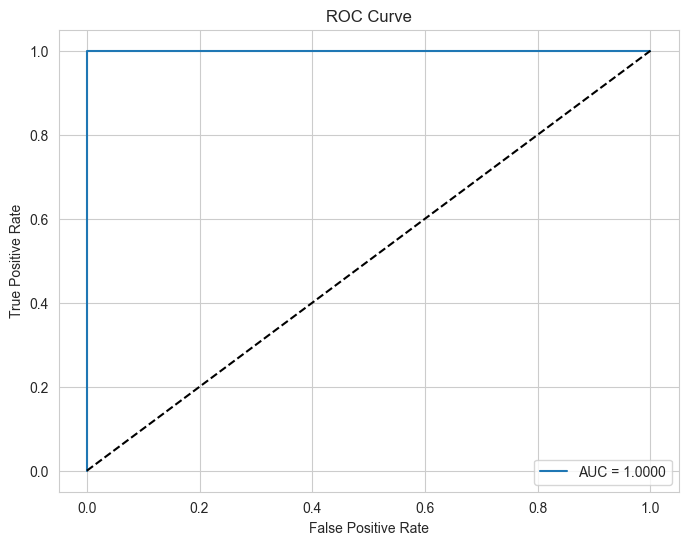

In [20]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()